# Fashion-MNIST Image Classification
### Deep Learning Implementation using PyTorch

____________

### Project Overview
This project implements and analyzes two different deep learning architectures to classify clothing items from the Fashion-MNIST dataset:

1. **Neural Network (NN)**: A Multi-Layer Perceptron (MLP) architecture.
2. **Convolutional Neural Network (CNN)**: A specialized architecture for spatial feature extraction in images.

The implementation includes data preprocessing, model definition, training loops, and performance evaluation.

### 1. Setup
Before running the code, ensure you have the following environment configuration:
- **Environment**: Local Python environment (VS Code) with version 3.10 to 3.12.
- **Hardware**: The code automatically detects and uses a GPU (via CUDA) if available; otherwise, it defaults to the CPU.
- **Data**: Ensure the `data/` folder contains the necessary dataset files, specifically `FashionMNIST_test.pth`.

In [2]:
import os
import torch

# Define relative paths based on your project structure (src -> data)
DATA_PATH = os.path.join('..', 'data')
TEST_MODEL_PATH = os.path.join(DATA_PATH, 'FashionMNIST_test.pth')

# Set device agnostic code (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Verify environment setup
print(f"Current working directory: {os.getcwd()}")
print(f"Data path: {DATA_PATH}")
print(f"Training on device: {device}")


Current working directory: c:\Users\User\Desktop\FashionMNIST-Image-Classification\src
Data path: ..\data
Training on device: cpu


### 2. Dataset Overview
For this project, we use the **Fashion-MNIST** dataset. This dataset contains 60,000 training images and 10,000 test images.

**Dataset Specifications:**
- **Image Size**: 28x28 pixels
- **Color Space**: Grayscale
- **Classes**: 10 distinct categories:
    - `T-shirt/top`, `Trouser`, `Pullover`, `Dress`, `Coat`
    - `Sandal`, `Shirt`, `Sneaker`, `Bag`, `Ankle boot`

The goal is to build a model that can correctly classify these images into their respective categories.

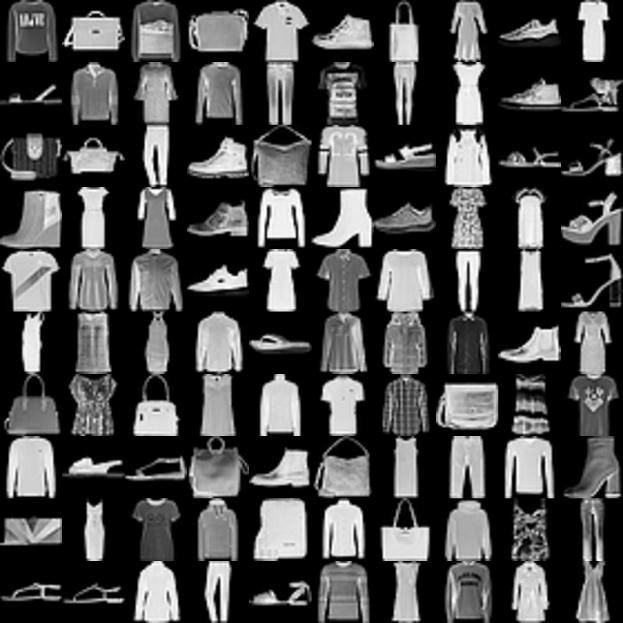

### 2.1 Data Loading and Preprocessing
We use `torchvision` to download and load the Fashion-MNIST dataset. To prepare the images for the neural network, we apply a transformation that:
1. Converts the images to **Tensors**.
2. **Normalizes** the pixel values to a range of [-1, 1] (with a mean and standard deviation of 0.5).

The data is loaded in **batches of 64** to balance memory efficiency and training stability.

In [5]:
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# The DATA_PATH was defined in the setup cell (../data)
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
mnist_data = datasets.FashionMNIST(root=DATA_PATH, download=True, train=True, transform=transform)
mnist_dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

print(f"Dataset size: {len(mnist_data)} images")

100.0%
100.0%
100.0%
100.0%

Dataset size: 60000 images


### 2.2 Data Exploration
To verify the data loading process, we inspect the dataset dimensions and visualize a few random samples. This helps ensure the normalization and batching are working as expected.

Total samples in dataset: 60000
Samples per batch: 64
Image dimensions: torch.Size([1, 28, 28])
Total labels: 60000


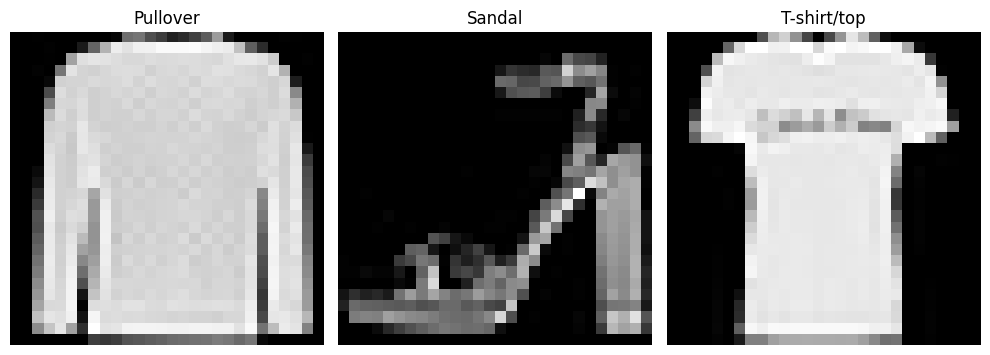

Labels in batch: ['Pullover', 'Sandal', 'T-shirt/top']


In [6]:
# Get a single batch for inspection
dataiter = iter(mnist_dataloader)
batch_images, batch_labels = next(dataiter)

# Dataset Statistics
print(f"Total samples in dataset: {len(mnist_data)}")
print(f"Samples per batch: {batch_images.shape[0]}")
print(f"Image dimensions: {batch_images[0].shape}")
print(f"Total labels: {len(mnist_data.targets)}")

# Visualization of random samples
label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

indices = np.random.choice(range(len(batch_images)), 3, replace=False)
plt.figure(figsize=(10, 4))

for i, idx in enumerate(indices):
    plt.subplot(1, 3, i + 1)
    # Squeeze is used to remove the channel dimension for grayscale plotting
    plt.imshow(batch_images[idx].numpy().squeeze(), cmap='Greys_r')
    plt.title(label_names[batch_labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Labels in batch:", [label_names[i] for i in batch_labels[indices]])

## 3. Neural Network Architecture
We implement a **Multi-Layer Perceptron (MLP)** to serve as our baseline model. Since a standard fully connected network requires vector inputs, we flatten the 28x28 images into 784-element vectors.

**Model Layers:**
1. **Input Layer**: 784 units (28x28 flattened pixels).
2. **Hidden Layer 1**: 128 units with **ReLU** activation.
3. **Hidden Layer 2**: 64 units with **ReLU** activation.
4. **Output Layer**: 10 units (one per class) with **Log-Softmax** activation.

This structure allows the model to learn non-linear relationships between pixel intensities and clothing categories.

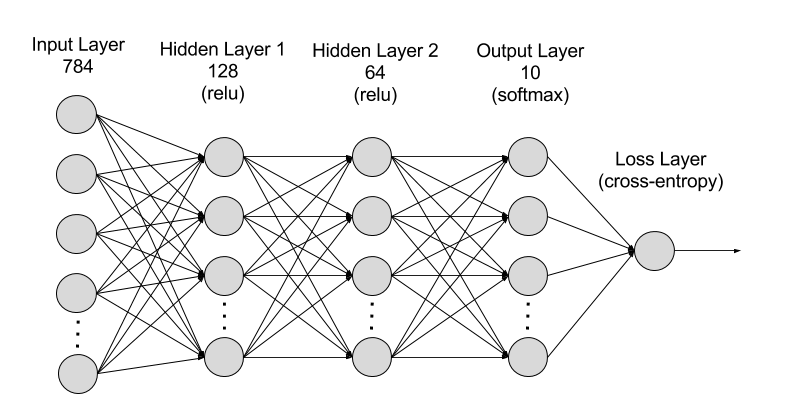

In [7]:
from torch import nn, optim
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        """
        Initialize the layers of the Multi-Layer Perceptron.
        """
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        """
        Defines the forward pass logic.
        """
        x = self.flatten(x)
        logits = self.network(x)
        return logits

# Instantiate the model and move it to the configured device
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


### Initial Model Inference (Untrained)
Before training, we test the model's forward pass with a random image. This step ensures that the input dimensions and the softmax output are correctly configured. 

At this stage, since the weights are randomly initialized, we expect the model to provide near-uniform probabilities across all 10 classes.

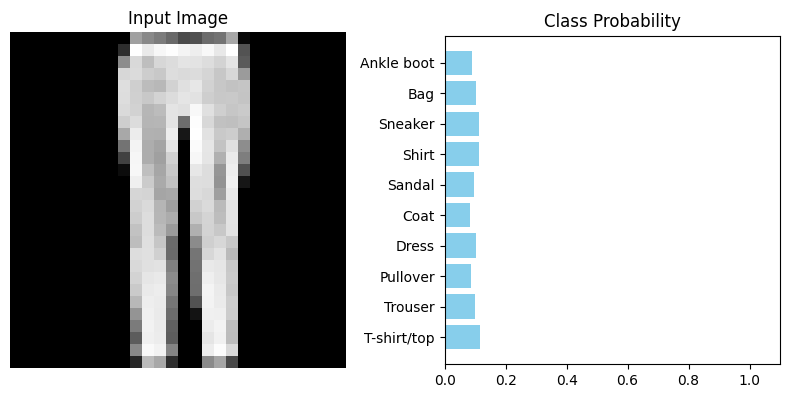

Confidence Scores:
 T-shirt/top : 0.11
 Trouser     : 0.10
 Pullover    : 0.09
 Dress       : 0.10
 Coat        : 0.08
 Sandal      : 0.10
 Shirt       : 0.11
 Sneaker     : 0.11
 Bag         : 0.10
 Ankle boot  : 0.09


In [8]:
def view_classify(img, ps):
    '''
    Visualize an image and its predicted class probabilities.
    img: Input image tensor
    ps: Class probabilities (tensor)
    '''
    ps = ps.data.cpu().numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
    
    # Image display
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Input Image')

    # Probability bar chart
    ax2.barh(np.arange(10), ps, color='skyblue')
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(label_names)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

def run_random_inference(data_loader, model):
    '''
    Selects a random image, performs inference, and displays results.
    '''
    # Get a batch and pick the first image
    images, labels = next(iter(data_loader))
    img = images[0].to(device) # Move to GPU/CPU

    # Turn off gradients for faster inference
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Flatten image for the MLP and get log-probabilities
        output = model(img.view(1, 784))
        # Convert log-probabilities to actual probabilities
        probabilities = torch.exp(output)

    # Move back to CPU for visualization
    view_classify(img.cpu(), probabilities.cpu())
    return probabilities

# Run the inference
preds_conf = run_random_inference(mnist_dataloader, model)

# Print detailed confidence scores (formatted to 2 decimal places)
print("Confidence Scores:")
for i, prob in enumerate(preds_conf[0]):
    print(f" {label_names[i]:<12}: {prob.item():.2f}")

### 4. Model Training
To train the model effectively, we split the data into two sets:
- **Training Set (80%)**: Used to update the model weights.
- **Validation Set (20%)**: Used to monitor the model's performance on unseen data and prevent overfitting.

We use the **Stochastic Gradient Descent (SGD)** optimizer and **Negative Log-Likelihood Loss (NLLLoss)**, which is standard for multi-class classification with a Log-Softmax output.

In [9]:
from torch.utils.data import random_split

# 1. Split dataset (80% Train, 20% Validation)
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_set, val_set = random_split(mnist_data, [train_size, val_size])

# 2. Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

# 3. Hyperparameters
learning_rate = 0.005
num_epochs = 5

# 4. Initialize Model, Optimizer, and Criterion
model = NeuralNetwork().to(device) # Ensure model is on the right device
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

print(f"Data split complete: {train_size} train samples, {val_size} validation samples.")

Data split complete: 48000 train samples, 12000 validation samples.


In [10]:
def train_model(model, optimizer, criterion, n_epochs, train_loader, val_loader, is_mlp=True):
    train_losses, val_losses = [], []
    
    for e in range(n_epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0
        
        for images, labels in train_loader:
            # Move data to the same device as model
            images, labels = images.to(device), labels.to(device)
            
            # Flatten images if using the MLP model
            if is_mlp:
                images = images.view(images.shape[0], -1)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Forward pass -> Compute loss -> Backward pass -> Update weights
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                if is_mlp:
                    images = images.view(images.shape[0], -1)
                
                val_output = model(images)
                val_loss = criterion(val_output, labels)
                running_val_loss += val_loss.item()
        
        # Track and print progress
        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {e+1}/{n_epochs}.. "
              f"Train Loss: {avg_train_loss:.3f}.. "
              f"Val Loss: {avg_val_loss:.3f}")
              
    return train_losses, val_losses

# Start Training
train_losses, val_losses = train_model(model, optimizer, criterion, num_epochs, 
                                       train_loader, val_loader, is_mlp=True)

Epoch 1/5.. Train Loss: 1.552.. Val Loss: 0.940
Epoch 2/5.. Train Loss: 0.763.. Val Loss: 0.682
Epoch 3/5.. Train Loss: 0.622.. Val Loss: 0.605
Epoch 4/5.. Train Loss: 0.562.. Val Loss: 0.556
Epoch 5/5.. Train Loss: 0.525.. Val Loss: 0.527


### Training Performance
The following plot visualizes the training and validation loss over time. This allows us to monitor the learning process and check for potential overfitting or underfitting.

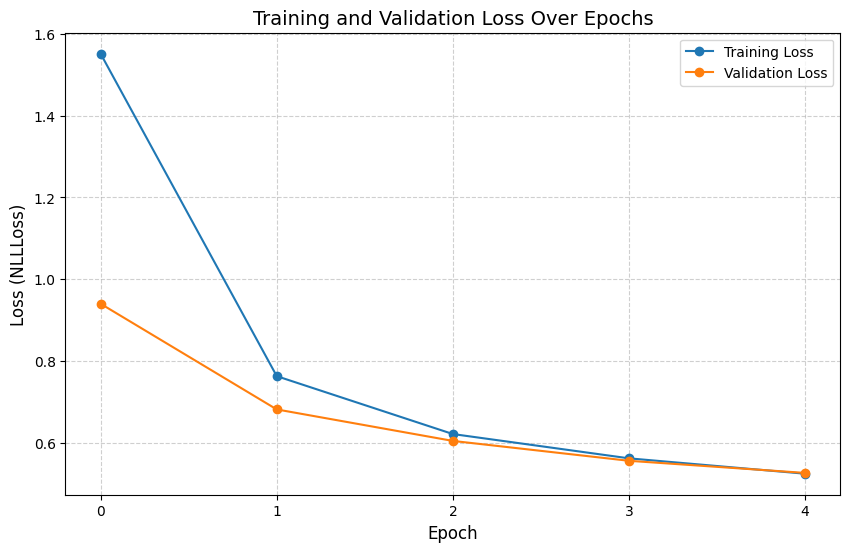

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')

# Formatting the graph
plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (NLLLoss)', fontsize=12)
plt.xticks(range(num_epochs)) # Show integer epoch numbers
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 5. Model Evaluation: Visualizing Predictions
Now that the model has been trained, we can test it on random samples from the dataset. Unlike the initial untrained model, we expect the probability distribution to show high confidence for the correct class.

Evaluating trained model on a random sample...


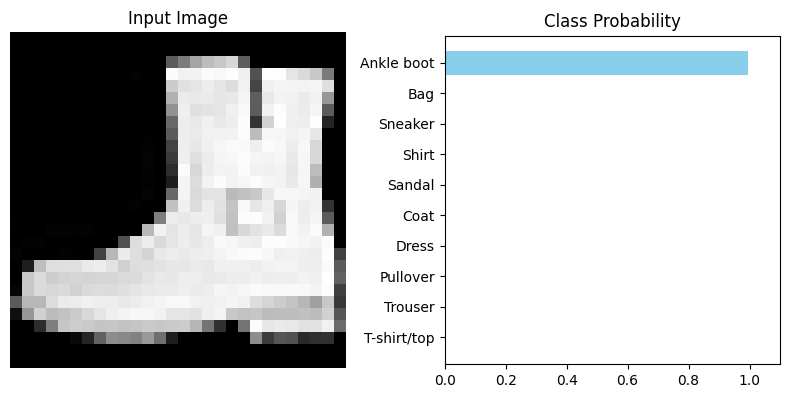

In [18]:
# Run inference on a random sample using the trained model
# You can run this cell multiple times to see different results
print("Evaluating trained model on a random sample...")
trained_preds = run_random_inference(mnist_dataloader, model)

### Performance Metrics: Accuracy
To quantify the model's performance, we calculate its **Accuracy** on the validation set. This represents the percentage of images the model correctly classified out of the total 12,000 validation samples.

In [19]:
def calculate_accuracy(model, data_loader, is_mlp=True):
    '''
    Calculate the total accuracy of the model on a given dataset.
    '''
    correct_count = 0
    total_samples = len(data_loader.dataset)
    
    model.eval() # Set to evaluation mode
    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the same device as the model
            images, labels = images.to(device), labels.to(device)
            
            if is_mlp:
                images = images.view(images.shape[0], -1)
            
            # Forward pass
            outputs = model(images)
            
            # Get the class with the highest probability
            # torch.max returns (values, indices), we only need indices
            _, predicted_classes = torch.max(outputs, dim=1)
            
            # Compare predictions with true labels
            correct_count += (predicted_classes == labels).sum().item()
            
    accuracy = (correct_count / total_samples) * 100
    return accuracy

# Execute evaluation
val_accuracy = calculate_accuracy(model, val_loader, is_mlp=True)
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Validation Accuracy: 81.09%


## Convolutional Neural Networks (CNN)

In this section, we transition from a standard Multi-Layer Perceptron (MLP) to a **Convolutional Neural Network (CNN)**. CNNs are specifically designed to process grid-like data such as images by capturing spatial hierarchies and local patterns.

### Key Concepts:
* **Convolutional Layers**: Use learnable filters (kernels) to extract features like edges, textures, and shapes.
* **Pooling (Max Pooling)**: Reduces the spatial dimensions (downsampling) to decrease computational load and prevent overfitting while retaining the most important information.
* **Stride & Padding**: Parameters that control the output dimensions of each layer and ensure edge information is preserved.

In [20]:
import torch
from torch import nn, optim
import torch.nn.functional as F

# Ensure device is still set correctly from the previous section
print(f"CNN section initialized on device: {device}")

CNN section initialized on device: cpu


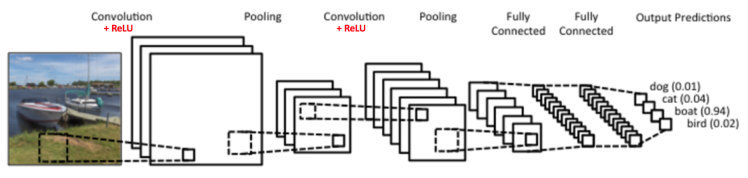

Reminder:  

- **Convolutional operation:** A “filter”, also called a “kernel”, is passed over the image, viewing a few pixels at a time (for example, 3X3 or 5X5). The convolution operation is a dot product of the original pixel values with weights defined in the filter. The results are summed up into one number that represents all the pixels the filter observed.

- **Pooling:** “Pooling” is the process of further downsampling and reducing the size of the matrix. A filter is passed over the results of the previous layer and selects one number out of each group of values (typically the maximum, this is called max pooling). This allows the network to train much faster, focusing on the most important information in each feature of the image. By sliding the window along the image, we compute the mean or the max of the portion of the image inside the window in case of MeanPooling or MaxPooling.

- **Stride:** The number of pixels to pass at a time when sliding the convolutional kernel.

- **Padding:** To preserve exactly the size of the input image, it is useful to add zero padding on the border of the image.

### CNN Architecture Definition
We define a Convolutional Neural Network with two convolutional stages followed by fully connected layers. This architecture excels at identifying local patterns in the Fashion-MNIST images.

**Layer Breakdown:**
1. **Convolutional Layer 1**: 10 filters of size 5x5.
2. **Max Pooling 1**: 2x2 kernel (reduces spatial size).
3. **Convolutional Layer 2**: 20 filters of size 5x5.
4. **Max Pooling 2**: 2x2 kernel (further reduction).
5. **Fully Connected 1**: 320 input units (flattened) $\rightarrow$ 50 output units.
6. **Fully Connected 2 (Output)**: 50 input units $\rightarrow$ 10 output units.

The final layer uses **Log-Softmax** to provide the class probabilities.

In [22]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Fully connected layers
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # First block: Conv -> Pool -> ReLU
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # Second block: Conv -> Pool -> ReLU
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        
        # Flatten the output for the fully connected layers
        # The size 320 comes from: 20 channels * 4 * 4 (spatial size)
        x = x.view(-1, 320)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Instantiate the model and move to device
cnn_model = ConvolutionalNet().to(device)
print(cnn_model)

ConvolutionalNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


We can now train the model on the train set.

In [23]:
# 1. Hyperparameters for CNN
cnn_nepochs = 3
cnn_learning_rate = 0.03

# 2. Initialize the CNN model, Optimizer and Criterion
# We use the ConvolutionalNet class defined earlier
cnn_model = ConvolutionalNet().to(device)
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=cnn_learning_rate)
cnn_criterion = nn.NLLLoss()

print(f"CNN Model initialized and moved to {device}")

CNN Model initialized and moved to cpu


In [24]:
# 3. Train the model
# Note: is_image_input=False because CNN works on 2D images
print("Starting CNN training process...")
cnn_train_losses, cnn_val_losses = train_model(
    cnn_model, 
    cnn_optimizer, 
    cnn_criterion, 
    cnn_nepochs, 
    train_loader, 
    val_loader, 
    is_mlp=False  # Crucial for CNN
)

Starting CNN training process...
Epoch 1/3.. Train Loss: 0.889.. Val Loss: 0.603
Epoch 2/3.. Train Loss: 0.522.. Val Loss: 0.476
Epoch 3/3.. Train Loss: 0.444.. Val Loss: 0.440


In [26]:
# 4. Final Accuracy Evaluation
# We use the accuracy function to see how the CNN performs
cnn_val_accuracy = calculate_accuracy(cnn_model, val_loader, is_mlp=False)

print("-" * 32)
print(f"CNN Validation Accuracy: {cnn_val_accuracy:.2f}%")
print("-" * 32)

--------------------------------
CNN Validation Accuracy: 84.01%
--------------------------------


### 3.3 Comparative Analysis: MLP vs. CNN

After evaluating both architectures, the results demonstrate the significant advantage of using convolutional layers for image classification tasks.

| Model Architecture | Epochs | Validation Accuracy |
| :--- | :---: | :---: |
| Simple Neural Network (MLP) | 5 | 81.09% |
| **Convolutional Neural Network (CNN)** | **3** | **84.01%** |



**Key Observation:**
The **CNN model** achieved a higher accuracy than the MLP, despite being trained for fewer epochs (3 vs. 5). This confirms that the convolutional filters are much more effective at extracting spatial features and patterns from the clothing images compared to the flattened input of the simple neural network. Even in this small-scale experiment, the CNN shows faster convergence and better overall performance.

___________